## **<u>Declaration of Independent Completion</u>**

We declare that we have completed this assignment in accordance with the UAB Academic Integrity Code and the UAB CS Honor Code. We have read the UAB Academic Integrity Code and understand that any breach of the Code may result in severe penalties.  
We also declare that the following percentage distribution faithfully represents individual group members’ contributions to the completion of the assignment.

| **<u>Name</u>** | **<u>Overall Contribution (%)</u>** | **<u>Major work items completed by me</u>** | **<u>Signature / Initials</u>** | **<u>Date</u>** |
|-----------------|-------------------------------------|----------------------------------------------|----------------------------------|------------------|
| **<u>Arbaz Ameer Khan</u>** | **20** | Implemented and debugged the training pipeline and model architecture | **<u>AAK</u>** | **<u>12/02/2025</u>** |
| **<u>Mahi Patel</u>** | **20** | Implemented and debugged the training pipeline and model architecture | **<u>MP</u>** | **<u>12/03/2025</u>** |
| **<u>Manav Sheth</u>** | **20** | Coordinated workflow, integrated components, led report writing | **<u>MS</u>** | **<u>12/05/2025</u>** |
| **<u>Tanmay Joshi</u>** | **20** | Implemented FGSM attack, ε sweep experiments, confusion matrix logic | **<u>TJ</u>** | **<u>12/05/2025</u>** |
| **<u>Krushil Patel</u>** | **20** | Created visualization code including plots, adversarial grids, and confidence histograms | **<u>KP</u>** | **<u>12/04/2025</u>** |

---

I/We **<u>Arbaz Ameer Khan</u>**, **<u>Mahi Patel</u>**, **<u>Manav Sheth</u>**, **<u>Tanmay Joshi</u>**, **<u>Krushil Patel</u>** declare that I/We have completed this computer code in accordance with the UAB Academic Integrity Code and the UAB CS Honor Code. I/We have read the UAB Academic Integrity Code and understand that any breach of the Code may result in severe penalties.

**<u>Student signature(s)/initials:</u>** **AAK, MP, MS, TJ, KP**  
**<u>Date:</u>** **12/05/2025**


# Setup

In [ ]:
import pickle
import matplotlib
matplotlib.use('Agg') #use non interactive backend to prevent crashes
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import gc

#hyperparameters
_batch_size_ = 64 #32 #128
_learning_rate_ = 0.01
_num_epochs_ = 3
_device_ = torch.device('cpu') #using cpu as the resource machines used by our group were weak

print('using device: ', _device_, '\n')

using device:  cpu 



# Dataset

In [ ]:
_transform_ = transforms.Compose([
    transforms.Resize(32), #32x32 minimum
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#We loaded the same dataset in two variables and then seprated the train and test using the batchsize
_train_dataset_ = datasets.MNIST(root='./data', train=True, download=True, transform=_transform_) #train=True
_test_dataset_ = datasets.MNIST(root='./data', train=False, download=True, transform=_transform_) #train=False

_train_loader_ = DataLoader(_train_dataset_, batch_size=_batch_size_, shuffle=True) #We used shuffle here as it would give us the random number of dataset size for train
_test_loader_ = DataLoader(_test_dataset_, batch_size=_batch_size_, shuffle=False)  #And here it will give us the starting batch without shuffle

print('train samples: ', len(_train_dataset_), '\n')
print('test samples: ', len(_test_dataset_), '\n')

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.92MB/s]

train samples:  60000 

test samples:  10000 



# Model architecture

In [ ]:
class _ResNetBlock_(nn.Module):
    def __init__(self, _in_channels_, _out_channels_, _stride_=1):
        super(_ResNetBlock_, self).__init__()
        self._conv1_ = nn.Conv2d(_in_channels_, _out_channels_, kernel_size=3, stride=_stride_, padding=1)
        self._bn1_ = nn.BatchNorm2d(_out_channels_)
        self._relu_ = nn.ReLU()
        self._conv2_ = nn.Conv2d(_out_channels_, _out_channels_, kernel_size=3, stride=1, padding=1)
        self._bn2_ = nn.BatchNorm2d(_out_channels_)

        self._shortcut_ = nn.Sequential()
        if _stride_ != 1 or _in_channels_ != _out_channels_:
            self._shortcut_ = nn.Sequential(
                nn.Conv2d(_in_channels_, _out_channels_, kernel_size=1, stride=_stride_),
                nn.BatchNorm2d(_out_channels_)
            )

    def forward(self, _x_):
        _out_ = self._relu_(self._bn1_(self._conv1_(_x_)))
        _out_ = self._bn2_(self._conv2_(_out_))
        _out_ = _out_ + self._shortcut_(_x_)
        _out_ = self._relu_(_out_)
        return _out_

#resnet model with reduced complexity
class _SimpleResNet_(nn.Module):
    def __init__(self):
        super(_SimpleResNet_, self).__init__()
        self._conv1_ = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self._bn1_ = nn.BatchNorm2d(8)
        self._relu_ = nn.ReLU()

        self._layer1_ = _ResNetBlock_(8, 8)
        self._layer2_ = _ResNetBlock_(8, 16, 2)
        self._layer3_ = _ResNetBlock_(16, 32, 2)

        self._avg_pool_ = nn.AdaptiveAvgPool2d((1, 1))
        self._fc_ = nn.Linear(32, 10)

    def forward(self, _x_):
        _out_ = self._relu_(self._bn1_(self._conv1_(_x_)))
        _out_ = self._layer1_(_out_)
        _out_ = self._layer2_(_out_)
        _out_ = self._layer3_(_out_)
        _out_ = self._avg_pool_(_out_)
        _out_ = _out_.view(_out_.size(0), -1)
        _out_ = self._fc_(_out_)
        return _out_

# Model and optimizer

In [ ]:
import torch.optim as optim

_model_ = _SimpleResNet_().to(_device_)
_criterion_ = nn.CrossEntropyLoss()
_optimizer_ = optim.Adam(_model_.parameters(), lr=_learning_rate_)

print('model created\n')
print('total parameters: ', sum(p.numel() for p in _model_.parameters()), '\n')

model created

total parameters:  19978 



# Training and testing functions

In [ ]:
#training function
def _train_one_epoch_(_epoch_):
    _model_.train()
    _total_loss_ = 0
    _correct_ = 0
    _total_ = 0

    for _batch_idx_, (_data_, _target_) in enumerate(_train_loader_):
        _data_ = _data_.to(_device_)
        _target_ = _target_.to(_device_)

        _optimizer_.zero_grad()
        _output_ = _model_(_data_)
        _loss_ = _criterion_(_output_, _target_)
        _loss_.backward()
        _optimizer_.step()

        _total_loss_ += _loss_.item()
        _pred_ = _output_.argmax(dim=1)
        _correct_ += _pred_.eq(_target_).sum().item()
        _total_ += _target_.size(0)

        if _batch_idx_ % 100 == 0:
            print('epoch: ', _epoch_, ' batch: ', _batch_idx_, ' loss: ', _loss_.item(), '\n')

    _accuracy_ = 100.0 * _correct_ / _total_
    _avg_loss_ = _total_loss_ / len(_train_loader_)
    return _avg_loss_, _accuracy_

#testing function
def _test_model_():
    _model_.eval()
    _correct_ = 0
    _total_ = 0

    with torch.no_grad():
        for _data_, _target_ in _test_loader_:
            _data_ = _data_.to(_device_)
            _target_ = _target_.to(_device_)

            _output_ = _model_(_data_)
            _pred_ = _output_.argmax(dim=1)
            _correct_ += _pred_.eq(_target_).sum().item()
            _total_ += _target_.size(0)

    _accuracy_ = 100.0 * _correct_ / _total_
    return _accuracy_

# Traning

In [ ]:
#train the model
_train_losses_ = []
_train_accuracies_ = []
_test_accuracies_ = []

print('starting training\n')

for _epoch_ in range(_num_epochs_):
    _train_loss_, _train_acc_ = _train_one_epoch_(_epoch_ + 1)
    _test_acc_ = _test_model_()

    _train_losses_.append(_train_loss_)
    _train_accuracies_.append(_train_acc_)
    _test_accuracies_.append(_test_acc_)

    print('epoch: ', _epoch_ + 1, ' train loss: ', _train_loss_, ' train acc: ', _train_acc_, ' test acc: ', _test_acc_, '\n')

print('training complete\n')
print('final test accuracy: ', _test_accuracies_[-1], '%\n')

starting training

epoch:  1  batch:  0  loss:  2.3356659412384033 

epoch:  1  batch:  100  loss:  0.2937684953212738 

epoch:  1  batch:  200  loss:  0.2806289494037628 

epoch:  1  batch:  300  loss:  0.09669878333806992 

epoch:  1  batch:  400  loss:  0.035150568932294846 

epoch:  1  batch:  500  loss:  0.09082618355751038 

epoch:  1  batch:  600  loss:  0.09144128859043121 

epoch:  1  batch:  700  loss:  0.14721786975860596 

epoch:  1  batch:  800  loss:  0.1591780185699463 

epoch:  1  batch:  900  loss:  0.09569171816110611 

epoch:  1  train loss:  0.20695820625529868  train acc:  93.97333333333333  test acc:  96.69 

epoch:  2  batch:  0  loss:  0.040622759610414505 

epoch:  2  batch:  100  loss:  0.042741600424051285 

epoch:  2  batch:  200  loss:  0.051112908869981766 

epoch:  2  batch:  300  loss:  0.012648873031139374 

epoch:  2  batch:  400  loss:  0.1118633896112442 

epoch:  2  batch:  500  loss:  0.09428495913743973 

epoch:  2  batch:  600  loss:  0.010533866

# Saving the model

In [ ]:
#our group decided to use saving the model as pickle file so we can collaborate easily and don't have to train the model again and again
_model_save_dict_ = {
    'model_state': _model_.state_dict(),
    'model_architecture': _SimpleResNet_,
    'optimizer_state': _optimizer_.state_dict(),
    'train_losses': _train_losses_,
    'train_accuracies': _train_accuracies_,
    'test_accuracies': _test_accuracies_
} #ensured the metadata of the model is to the point

with open('final_resnet_mnist_model.pkl', 'wb') as _f_:
    pickle.dump(_model_save_dict_, _f_)

print('model saved to final_resnet_mnist_model.pkl\n')

#clearing memory
#as our resource machines were with limited power at even though we had a RTX 2050 but the kernal with ram inclusion was not sufficent and was restarting when plotting so it was decided by Arbaz Ameer to clear the memory reload the model for plotting graphs, testing or any other change
del _train_loader_
del _test_loader_
gc.collect()

model saved to final_resnet_mnist_model.pkl



3488

# Training graphs

In [ ]:
#load the pickle file
with open('final_resnet_mnist_model.pkl', 'rb') as _f_:
    _saved_data_ = pickle.load(_f_)

_train_losses_ = _saved_data_['train_losses']
_train_accuracies_ = _saved_data_['train_accuracies']
_test_accuracies_ = _saved_data_['test_accuracies']
_model_architecture_ = _saved_data_['model_architecture']
_model_state_ = _saved_data_['model_state']

_num_epochs_ = len(_train_losses_)

print('model data loaded successfully\n')
print('number of epochs: ', _num_epochs_, '\n')
print('final train accuracy: ', _train_accuracies_[-1], '%\n')
print('final test accuracy: ', _test_accuracies_[-1], '%\n')


#print training data instead of plotting
print('training data summary\n')
print('number of epochs: ', _num_epochs_, '\n')

print('epoch by epoch results:\n')
for _i_ in range(_num_epochs_):
    print('epoch ', _i_ + 1, ':\n')
    print('  train loss: ', _train_losses_[_i_], '\n')
    print('  train accuracy: ', _train_accuracies_[_i_], '%\n')
    print('  test accuracy: ', _test_accuracies_[_i_], '%\n')
    print('\n')

print('final results:\n')
print('final train loss: ', _train_losses_[-1], '\n')
print('final train accuracy: ', _train_accuracies_[-1], '%\n')
print('final test accuracy: ', _test_accuracies_[-1], '%\n')

#save data to text file for later plotting
with open('training_data.txt', 'w') as _f_:
    _f_.write('Epoch,Train_Loss,Train_Accuracy,Test_Accuracy\n')
    for _i_ in range(_num_epochs_):
        _f_.write(str(_i_ + 1) + ',' + str(_train_losses_[_i_]) + ',' + str(_train_accuracies_[_i_]) + ',' + str(_test_accuracies_[_i_]) + '\n')

model data loaded successfully

number of epochs:  3 

final train accuracy:  98.36333333333333 %

final test accuracy:  98.57 %

training data summary

number of epochs:  3 

epoch by epoch results:

epoch  1 :

  train loss:  0.20695820625529868 

  train accuracy:  93.97333333333333 %

  test accuracy:  96.69 %



epoch  2 :

  train loss:  0.07041896172840871 

  train accuracy:  97.78833333333333 %

  test accuracy:  97.06 %



epoch  3 :

  train loss:  0.053259394674706875 

  train accuracy:  98.36333333333333 %

  test accuracy:  98.57 %



final results:

final train loss:  0.053259394674706875 

final train accuracy:  98.36333333333333 %

final test accuracy:  98.57 %



In [ ]:
print('recreating model for testing\n')

_device_ = torch.device('cpu')

#recreate model and load weights
_model_ = _SimpleResNet_()
_model_.load_state_dict(_model_state_)
_model_ = _model_.to(_device_)
_model_.eval()

print('model loaded and ready for testing\n')

print('loading test dataset\n')

_transform_ = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

_test_dataset_ = datasets.MNIST(root='./data', train=False, download=False, transform=_transform_)
_test_loader_ = DataLoader(_test_dataset_, batch_size=64, shuffle=False)

print('test dataset loaded\n')

print('testing model on full test set\n')

_model_.eval()
_correct_ = 0
_total_ = 0

with torch.no_grad():
    for _data_, _target_ in _test_loader_:
        _data_ = _data_.to(_device_)
        _target_ = _target_.to(_device_)

        _output_ = _model_(_data_)
        _pred_ = _output_.argmax(dim=1)
        _correct_ += _pred_.eq(_target_).sum().item()
        _total_ += _target_.size(0)

_final_accuracy_ = 100.0 * _correct_ / _total_

print('total test samples: ', _total_, '\n')
print('correct predictions: ', _correct_, '\n')
print('test accuracy: ', _final_accuracy_, '%\n')

recreating model for testing

model loaded and ready for testing

loading test dataset

test dataset loaded

testing model on full test set

total test samples:  10000 

correct predictions:  9857 

test accuracy:  98.57 %



testing individual samples

sample  1 :

true label:  7 

predicted label:  7 

confidence:  99.99438524246216 %

correct:  True 


sample  2 :

true label:  2 

predicted label:  2 

confidence:  99.99449253082275 %

correct:  True 


sample  3 :

true label:  1 

predicted label:  1 

confidence:  99.99221563339233 %

correct:  True 




/tmp/ipython-input-3300710065.py:47: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  _pil_img_ = Image.fromarray(_img_array_, mode='L')


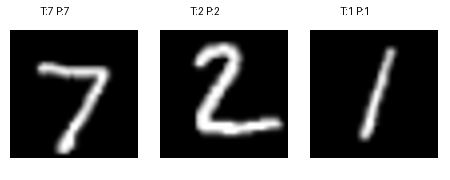

sample predictions saved to sample_predictions.png



In [ ]:
print('testing individual samples\n')

_num_samples_to_show_ = 3 #change this number

_test_iter_ = iter(_test_loader_)
_sample_data_, _sample_labels_ = next(_test_iter_)

#print predictions first
for _i_ in range(_num_samples_to_show_):
    _img_ = _sample_data_[_i_].to(_device_)
    _true_label_ = _sample_labels_[_i_].item()

    with torch.no_grad():
        _output_ = _model_(_img_.unsqueeze(0))
        _pred_label_ = _output_.argmax(dim=1).item()
        _confidence_ = torch.softmax(_output_, dim=1)[0][_pred_label_].item() * 100

    print('sample ', _i_ + 1, ':\n')
    print('true label: ', _true_label_, '\n')
    print('predicted label: ', _pred_label_, '\n')
    print('confidence: ', _confidence_, '%\n')
    print('correct: ', _true_label_ == _pred_label_, '\n\n')

#create sample images without matplotlib
try:
    from PIL import Image, ImageDraw
    import numpy as np

    _combined_width_ = 150 * _num_samples_to_show_
    _combined_height_ = 180
    _combined_img_ = Image.new('RGB', (_combined_width_, _combined_height_), color='white')
    _combined_draw_ = ImageDraw.Draw(_combined_img_)

    for _i_ in range(_num_samples_to_show_):
        _img_ = _sample_data_[_i_].to(_device_)
        _true_label_ = _sample_labels_[_i_].item()

        with torch.no_grad():
            _output_ = _model_(_img_.unsqueeze(0))
            _pred_label_ = _output_.argmax(dim=1).item()

        #get image array and normalize
        _img_array_ = _sample_data_[_i_].squeeze().cpu().numpy()
        _img_array_ = ((_img_array_ + 1) * 127.5).astype(np.uint8)

        #create PIL image and resize
        _pil_img_ = Image.fromarray(_img_array_, mode='L')
        _pil_img_ = _pil_img_.resize((128, 128))

        #paste into combined image
        _x_offset_ = _i_ * 150 + 10
        _combined_img_.paste(_pil_img_, (_x_offset_, 30))

        #add text
        _text_ = 'T:' + str(_true_label_) + ' P:' + str(_pred_label_)
        _combined_draw_.text((_x_offset_ + 30, 5), _text_, fill='black')

    _combined_img_.save('sample_predictions.png')
    display(_combined_img_)

    del _combined_img_
    del _combined_draw_
    gc.collect()

    print('sample predictions saved to sample_predictions.png\n')

except Exception as _e_:
    print('could not create sample image error: ', _e_, '\n')

# FGSM (Fast Gradient Sign Method) adversarial attack:

_fgsm_attack_() - Creates adversarial perturbations using gradient sign

_test_attack_on_image_() - Tests attack on single image

_Attack hyperparameter_: _epsilon_ = 0.1 (0.05, 0.1, 0.15, 0.2, 0.3)

_num_samples_to_attack_ = 1000 (change to 10000 for full test set)

In [ ]:
#test attack with multiple epsilon values
with open('final_resnet_mnist_model.pkl', 'rb') as _f_:
    _saved_data_ = pickle.load(_f_)

_device_ = torch.device('cpu')
_model_ = _SimpleResNet_()
_model_.load_state_dict(_saved_data_['model_state'])
_model_ = _model_.to(_device_)
_model_.eval()

_transform_ = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

_test_dataset_ = datasets.MNIST(root='./data', train=False, download=False, transform=_transform_)
_test_loader_ = DataLoader(_test_dataset_, batch_size=1, shuffle=False)
#setup completes here for loading the saved model for attack

#fgsm attack function
def _fgsm_attack_(_image_, _epsilon_, _data_grad_):
    _sign_grad_ = _data_grad_.sign()
    _perturbed_image_ = _image_ + _epsilon_ * _sign_grad_
    _perturbed_image_ = torch.clamp(_perturbed_image_, -1, 1)
    return _perturbed_image_

#function to evaluate attack at one epsilon
def _evaluate_epsilon_(_model_, _device_, _test_loader_, _epsilon_, _num_samples_):
    _correct_clean_ = 0
    _correct_adv_ = 0
    _total_ = 0
    _attack_success_ = 0

    _clean_confidences_ = []
    _adv_confidences_ = []

    _criterion_ = nn.CrossEntropyLoss()

    for _idx_, (_data_, _target_) in enumerate(_test_loader_):
        if _idx_ >= _num_samples_:
            break

        _data_ = _data_.to(_device_)
        _target_ = _target_.to(_device_)
        _data_.requires_grad = True

        #clean prediction
        _output_ = _model_(_data_)
        _clean_pred_ = _output_.argmax(dim=1).item()
        _clean_conf_ = torch.softmax(_output_, dim=1)[0][_clean_pred_].item()

        if _clean_pred_ == _target_.item():
            _correct_clean_ += 1
            _total_ += 1

            #generate adversarial
            _loss_ = _criterion_(_output_, _target_)
            _model_.zero_grad()
            _loss_.backward()
            _data_grad_ = _data_.grad.data

            _perturbed_ = _fgsm_attack_(_data_, _epsilon_, _data_grad_)

            #adversarial prediction
            _output_adv_ = _model_(_perturbed_)
            _adv_pred_ = _output_adv_.argmax(dim=1).item()
            _adv_conf_ = torch.softmax(_output_adv_, dim=1)[0][_adv_pred_].item()

            _clean_confidences_.append(_clean_conf_)
            _adv_confidences_.append(_adv_conf_)

            if _adv_pred_ == _target_.item():
                _correct_adv_ += 1
            else:
                _attack_success_ += 1

    _clean_acc_ = 100.0 * _correct_clean_ / _total_ if _total_ > 0 else 0
    _adv_acc_ = 100.0 * _correct_adv_ / _total_ if _total_ > 0 else 0
    _asr_ = 100.0 * _attack_success_ / _total_ if _total_ > 0 else 0

    return _clean_acc_, _adv_acc_, _asr_, _clean_confidences_, _adv_confidences_

#epsilon values to test
_epsilon_values_ = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
_num_samples_per_epsilon_ = 1000 #number of sampless tested

print('testing multiple epsilon values\n')
print('epsilon values: ', _epsilon_values_, '\n')
print('samples per epsilon: ', _num_samples_per_epsilon_, '\n')

_results_ = {}

for _eps_ in _epsilon_values_:
    print('testing epsilon: ', _eps_, '\n')
    _clean_acc_, _adv_acc_, _asr_, _clean_conf_, _adv_conf_ = _evaluate_epsilon_(_model_, _device_, _test_loader_, _eps_, _num_samples_per_epsilon_)

    _results_[_eps_] = {
        'clean_accuracy': _clean_acc_,
        'adversarial_accuracy': _adv_acc_,
        'attack_success_rate': _asr_,
        'clean_confidences': _clean_conf_,
        'adversarial_confidences': _adv_conf_
    }

    print('  clean acc: ', round(_clean_acc_, 2), '%\n')
    print('  adversarial acc: ', round(_adv_acc_, 2), '%\n')
    print('  attack success rate: ', round(_asr_, 2), '%\n')

#saving the attacked model in another file, this will be used later for further validation using graphs
with open('epsilon_sweep_results.pkl', 'wb') as _f_:
    pickle.dump(_results_, _f_)

print('results saved to epsilon_sweep_results.pkl\n')

#generate confusion matrices for clean and adversarial
_epsilon_for_cm_ = 0.15 #epsilon to use for confusion matrix

_clean_cm_ = [[0 for _ in range(10)] for _ in range(10)]
_adv_cm_ = [[0 for _ in range(10)] for _ in range(10)]

_criterion_ = nn.CrossEntropyLoss()
_num_samples_cm_ = 1000 #samples for confusion matrix

for _idx_, (_data_, _target_) in enumerate(_test_loader_):
    if _idx_ >= _num_samples_cm_:
        break

    _data_ = _data_.to(_device_)
    _target_ = _target_.to(_device_)
    _true_label_ = _target_.item()

    #clean prediction
    _output_ = _model_(_data_)
    _clean_pred_ = _output_.argmax(dim=1).item()
    _clean_cm_[_true_label_][_clean_pred_] += 1

    #generate adversarial
    _data_.requires_grad = True
    _output_ = _model_(_data_)
    _loss_ = _criterion_(_output_, _target_)
    _model_.zero_grad()
    _loss_.backward()
    _data_grad_ = _data_.grad.data

    _perturbed_ = _fgsm_attack_(_data_, _epsilon_for_cm_, _data_grad_)

    #adversarial prediction
    _output_adv_ = _model_(_perturbed_)
    _adv_pred_ = _output_adv_.argmax(dim=1).item()
    _adv_cm_[_true_label_][_adv_pred_] += 1

#save confusion matrices
_cm_data_ = {
    'clean': _clean_cm_,
    'adversarial': _adv_cm_,
    'epsilon': _epsilon_for_cm_
}

with open('confusion_matrices.pkl', 'wb') as _f_:
    pickle.dump(_cm_data_, _f_)

print('confusion matrices saved to confusion_matrices.pkl\n')


#collecting visual examples for grid
_visual_examples_ = []
_num_visual_examples_ = 16 #4x4 grid
_epsilon_visual_ = 0.15 #epsilon for visualization

_criterion_ = nn.CrossEntropyLoss()

for _idx_, (_data_, _target_) in enumerate(_test_loader_):
    if len(_visual_examples_) >= _num_visual_examples_:
        break

    _data_ = _data_.to(_device_)
    _target_ = _target_.to(_device_)

    #check if correctly classified
    _output_ = _model_(_data_)
    _clean_pred_ = _output_.argmax(dim=1).item()

    if _clean_pred_ == _target_.item():
        #generate adversarial
        _data_.requires_grad = True
        _output_ = _model_(_data_)
        _loss_ = _criterion_(_output_, _target_)
        _model_.zero_grad()
        _loss_.backward()
        _data_grad_ = _data_.grad.data

        _perturbed_ = _fgsm_attack_(_data_, _epsilon_visual_, _data_grad_)

        #adversarial prediction
        _output_adv_ = _model_(_perturbed_)
        _adv_pred_ = _output_adv_.argmax(dim=1).item()

        #calculate perturbation
        _perturbation_ = _perturbed_ - _data_

        _visual_examples_.append({
            'original': _data_.cpu().detach().squeeze().numpy(),
            'adversarial': _perturbed_.cpu().detach().squeeze().numpy(),
            'perturbation': _perturbation_.cpu().detach().squeeze().numpy(),
            'true_label': _target_.item(),
            'clean_pred': _clean_pred_,
            'adv_pred': _adv_pred_
        })

#save visual examples model in another file to show for validation
with open('visual_examples.pkl', 'wb') as _f_:
    pickle.dump({'examples': _visual_examples_, 'epsilon': _epsilon_visual_}, _f_)

print('collected ', len(_visual_examples_), ' visual examples\n')
print('visual examples saved to visual_examples.pkl\n')


#saving all data for plotting in files so that we don't have to run the same cell again and recreate everything if needed
print('saving all data for graphs\n')

#save data in txt
with open('graph_data.txt', 'w') as _f_:
    _f_.write('ADVERSARIAL ATTACK VISUALIZATION DATA\n')
    _f_.write('='*50 + '\n\n')

    #graph 1 and 3 epsilon vs accuracy
    _f_.write('GRAPH 1 & 3: Epsilon vs Accuracy\n')
    _f_.write('Epsilon,Clean_Accuracy,Adversarial_Accuracy\n')
    for _eps_ in _epsilon_values_:
        _f_.write(str(_eps_) + ',' + str(round(_results_[_eps_]['clean_accuracy'], 2)) + ',' + str(round(_results_[_eps_]['adversarial_accuracy'], 2)) + '\n')
    _f_.write('\n')

    #graph 2 and 4 epsilon vs asr
    _f_.write('GRAPH 2 & 4: Epsilon vs Attack Success Rate\n')
    _f_.write('Epsilon,ASR\n')
    for _eps_ in _epsilon_values_:
        _f_.write(str(_eps_) + ',' + str(round(_results_[_eps_]['attack_success_rate'], 2)) + '\n')
    _f_.write('\n')

    #bar chart data
    _f_.write('BAR CHART DATA:\n')
    _f_.write('Clean Accuracy: ' + str(round(_results_[0.0]['clean_accuracy'], 2)) + '%\n')
    _f_.write('FGSM (eps=0.1) Accuracy: ' + str(round(_results_[0.1]['adversarial_accuracy'], 2)) + '%\n')
    _f_.write('FGSM (eps=0.15) Accuracy: ' + str(round(_results_[0.15]['adversarial_accuracy'], 2)) + '%\n')
    _f_.write('\n')

    #confidence data
    _f_.write('CONFIDENCE DROP DATA (eps=0.15):\n')
    _avg_clean_conf_ = sum(_results_[0.15]['clean_confidences']) / len(_results_[0.15]['clean_confidences'])
    _avg_adv_conf_ = sum(_results_[0.15]['adversarial_confidences']) / len(_results_[0.15]['adversarial_confidences'])
    _f_.write('Average Clean Confidence: ' + str(round(_avg_clean_conf_ * 100, 2)) + '%\n')
    _f_.write('Average Adversarial Confidence: ' + str(round(_avg_adv_conf_ * 100, 2)) + '%\n')
    _f_.write('Confidence Drop: ' + str(round((_avg_clean_conf_ - _avg_adv_conf_) * 100, 2)) + '%\n')

print('all graph data saved to graph_data.txt\n')

#print summary
print('summary of results:\n')
print('epsilon values tested: ', _epsilon_values_, '\n')
for _eps_ in _epsilon_values_:
    print('epsilon ', _eps_, ':\n')
    print('  adversarial accuracy: ', round(_results_[_eps_]['adversarial_accuracy'], 2), '%\n')
    print('  attack success rate: ', round(_results_[_eps_]['attack_success_rate'], 2), '%\n')

print('all data collected successfully\n')
print('files created:\n')
print('  epsilon_sweep_results.pkl\n')
print('  confusion_matrices.pkl\n')
print('  visual_examples.pkl\n')
print('  graph_data.txt\n')

testing multiple epsilon values

epsilon values:  [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3] 

samples per epsilon:  1000 

testing epsilon:  0.0 

  clean acc:  100.0 %

  adversarial acc:  100.0 %

  attack success rate:  0.0 %

testing epsilon:  0.05 

  clean acc:  100.0 %

  adversarial acc:  88.65 %

  attack success rate:  11.35 %

testing epsilon:  0.1 

  clean acc:  100.0 %

  adversarial acc:  59.2 %

  attack success rate:  40.8 %

testing epsilon:  0.15 

  clean acc:  100.0 %

  adversarial acc:  32.0 %

  attack success rate:  68.0 %

testing epsilon:  0.2 

  clean acc:  100.0 %

  adversarial acc:  16.16 %

  attack success rate:  83.84 %

testing epsilon:  0.25 

  clean acc:  100.0 %

  adversarial acc:  13.29 %

  attack success rate:  86.71 %

testing epsilon:  0.3 

  clean acc:  100.0 %

  adversarial acc:  11.86 %

  attack success rate:  88.14 %

results saved to epsilon_sweep_results.pkl

confusion matrices saved to confusion_matrices.pkl

collected  16  visual ex

In [ ]:
import os
os.environ['MPLBACKEND'] = 'Agg'

#load results
with open('epsilon_sweep_results.pkl', 'rb') as _f_:
    _results_ = pickle.load(_f_)

with open('visual_examples.pkl', 'rb') as _f_:
    _visual_data_ = pickle.load(_f_)
    _visual_examples_ = _visual_data_['examples']

_epsilon_values_ = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

print('creating graphs\n')

#graph 1 clean vs adversarial accuracy bar chart
print('creating graph 1 bar chart\n')

#plt.close('all')
_fig_, _ax_ = plt.subplots(figsize=(10, 6))

_categories_ = ['Clean', 'FGSM\neps=0.1', 'FGSM\neps=0.15']
_accuracies_ = [
    _results_[0.0]['clean_accuracy'],
    _results_[0.1]['adversarial_accuracy'],
    _results_[0.15]['adversarial_accuracy']
]
_colors_ = ['green', 'orange', 'red']

_ax_.bar(_categories_, _accuracies_, color=_colors_, alpha=0.7, width=0.6)
_ax_.set_ylabel('Accuracy (%)', fontsize=12)
_ax_.set_title('Clean vs Adversarial Accuracy', fontsize=14, fontweight='bold')
_ax_.set_ylim(0, 100)
_ax_.grid(axis='y', alpha=0.3)

for _i_, _v_ in enumerate(_accuracies_):
    _ax_.text(_i_, _v_ + 2, str(round(_v_, 1)) + '%', ha='center', fontsize=11)

_fig_.tight_layout()
_fig_.savefig('graph1_accuracy_bar_chart.png', dpi=150, bbox_inches='tight')
plt.show()
#plt.close(_fig_)
#del _fig_
#del _ax_

print('graph 1 saved\n')


#graph 2 attack success rate bar chart
print('creating graph 2 asr bar chart\n')

_fig_, _ax_ = plt.subplots(figsize=(10, 6))

_asr_values_ = [
    _results_[0.1]['attack_success_rate'],
    _results_[0.15]['attack_success_rate'],
    _results_[0.2]['attack_success_rate']
]
_asr_labels_ = ['eps=0.1', 'eps=0.15', 'eps=0.2']

_ax_.bar(_asr_labels_, _asr_values_, color='red', alpha=0.7, width=0.5)
_ax_.set_ylabel('Attack Success Rate (%)', fontsize=12)
_ax_.set_xlabel('Epsilon', fontsize=12)
_ax_.set_title('Attack Success Rate (ASR)', fontsize=14, fontweight='bold')
_ax_.set_ylim(0, 100)
_ax_.grid(axis='y', alpha=0.3)

for _i_, _v_ in enumerate(_asr_values_):
    _ax_.text(_i_, _v_ + 2, str(round(_v_, 1)) + '%', ha='center', fontsize=11)

_fig_.tight_layout()
_fig_.savefig('graph2_asr_bar_chart.png', dpi=150, bbox_inches='tight')
plt.show()
#plt.close(_fig_)
#del _fig_
#del _ax_

print('graph 2 saved\n')


#graph 3 epsilon vs accuracy curve
print('creating graph 3 epsilon vs accuracy\n')

_fig_, _ax_ = plt.subplots(figsize=(10, 6))

_clean_accs_ = [_results_[_e_]['clean_accuracy'] for _e_ in _epsilon_values_]
_adv_accs_ = [_results_[_e_]['adversarial_accuracy'] for _e_ in _epsilon_values_]

_ax_.plot(_epsilon_values_, _clean_accs_, marker='o', linewidth=2, markersize=8, label='Clean Accuracy', color='green')
_ax_.plot(_epsilon_values_, _adv_accs_, marker='s', linewidth=2, markersize=8, label='Adversarial Accuracy', color='red')

_ax_.set_xlabel('Epsilon (ε)', fontsize=12)
_ax_.set_ylabel('Accuracy (%)', fontsize=12)
_ax_.set_title('Epsilon vs Accuracy Curve', fontsize=14, fontweight='bold')
_ax_.legend(fontsize=11)
_ax_.grid(True, alpha=0.3)
_ax_.set_ylim(0, 105)

_fig_.tight_layout()
_fig_.savefig('graph3_epsilon_vs_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()
#plt.close(_fig_)
#del _fig_
#del _ax_

print('graph 3 saved\n')


#graph 4 epsilon vs asr curve
print('creating graph 4 epsilon vs asr\n')

_fig_, _ax_ = plt.subplots(figsize=(10, 6))

_asr_curve_ = [_results_[_e_]['attack_success_rate'] for _e_ in _epsilon_values_]

_ax_.plot(_epsilon_values_, _asr_curve_, marker='D', linewidth=2, markersize=8, color='red')
_ax_.set_xlabel('Epsilon (ε)', fontsize=12)
_ax_.set_ylabel('Attack Success Rate (%)', fontsize=12)
_ax_.set_title('Epsilon vs Attack Success Rate', fontsize=14, fontweight='bold')
_ax_.grid(True, alpha=0.3)
_ax_.set_ylim(0, 105)

_fig_.tight_layout()
_fig_.savefig('graph4_epsilon_vs_asr.png', dpi=150, bbox_inches='tight')
plt.show()
#plt.close(_fig_)
#del _fig_
#del _ax_

print('graph 4 saved\n')


#graph 5 original vs adversarial image grid
print('creating graph 5 image grid\n')

_num_cols_ = 4
_num_rows_ = 3
_num_images_ = min(len(_visual_examples_), _num_cols_)

_fig_, _axes_ = plt.subplots(_num_rows_, _num_cols_, figsize=(12, 9))

for _i_ in range(_num_images_):
    _ex_ = _visual_examples_[_i_]

    _axes_[0, _i_].imshow(_ex_['original'], cmap='gray')
    _axes_[0, _i_].set_title('Original\nTrue: ' + str(_ex_['true_label']) + ' Pred: ' + str(_ex_['clean_pred']), fontsize=9)
    _axes_[0, _i_].axis('off')

    _axes_[1, _i_].imshow(_ex_['adversarial'], cmap='gray')
    _axes_[1, _i_].set_title('Adversarial\nPred: ' + str(_ex_['adv_pred']), fontsize=9)
    _axes_[1, _i_].axis('off')

    _pert_mag_ = _ex_['perturbation'] * 10
    _axes_[2, _i_].imshow(_pert_mag_, cmap='gray')
    _axes_[2, _i_].set_title('Perturbation x10', fontsize=9)
    _axes_[2, _i_].axis('off')

_fig_.suptitle('Original vs Adversarial Images (eps=' + str(_visual_data_['epsilon']) + ')', fontsize=14, fontweight='bold')
_fig_.tight_layout()
_fig_.savefig('graph5_image_grid.png', dpi=150, bbox_inches='tight')
plt.show()
#plt.close(_fig_)
#del _fig_
#del _axes_

print('graph 5 saved\n')


#graph 6 training loss curves
print('creating graph 6 training curves\n')

try:
    with open('final_resnet_mnist_model.pkl', 'rb') as _f_:
        _model_data_ = pickle.load(_f_)

    _train_losses_ = _model_data_['train_losses']
    _train_accs_ = _model_data_['train_accuracies']
    _test_accs_ = _model_data_['test_accuracies']
    _epochs_ = list(range(1, len(_train_losses_) + 1))

    _fig_, _axes_ = plt.subplots(1, 2, figsize=(12, 5))

    _axes_[0].plot(_epochs_, _train_losses_, marker='o', linewidth=2, color='blue')
    _axes_[0].set_xlabel('Epoch', fontsize=11)
    _axes_[0].set_ylabel('Loss', fontsize=11)
    _axes_[0].set_title('Training Loss', fontsize=12, fontweight='bold')
    _axes_[0].grid(True, alpha=0.3)

    _axes_[1].plot(_epochs_, _train_accs_, marker='o', linewidth=2, label='Train', color='green')
    _axes_[1].plot(_epochs_, _test_accs_, marker='s', linewidth=2, label='Test', color='orange')
    _axes_[1].set_xlabel('Epoch', fontsize=11)
    _axes_[1].set_ylabel('Accuracy (%)', fontsize=11)
    _axes_[1].set_title('Training & Test Accuracy', fontsize=12, fontweight='bold')
    _axes_[1].legend(fontsize=10)
    _axes_[1].grid(True, alpha=0.3)

    _fig_.tight_layout()
    _fig_.savefig('graph6_training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    #plt.close(_fig_)
    #del _fig_
    #del _axes_

    print('graph 6 saved\n')
except:
    print('graph 6 skipped\n')


#graph 7 confusion matrices
print('creating graph 7 confusion matrices\n')

try:
    with open('confusion_matrices.pkl', 'rb') as _f_:
        _cm_data_ = pickle.load(_f_)

    _clean_cm_ = np.array(_cm_data_['clean'])
    _adv_cm_ = np.array(_cm_data_['adversarial'])

    _fig_, _axes_ = plt.subplots(1, 2, figsize=(14, 6))

    _im1_ = _axes_[0].imshow(_clean_cm_, cmap='Blues')
    _axes_[0].set_title('Clean Confusion Matrix', fontsize=12, fontweight='bold')
    plt.colorbar(_im1_, ax=_axes_[0])

    _im2_ = _axes_[1].imshow(_adv_cm_, cmap='Reds')
    _axes_[1].set_title('Adversarial Confusion Matrix', fontsize=12, fontweight='bold')
    plt.colorbar(_im2_, ax=_axes_[1])

    _fig_.tight_layout()
    _fig_.savefig('graph7_confusion_matrices.png', dpi=150, bbox_inches='tight')
    plt.show()
    #plt.close(_fig_)
    #del _fig_
    #del _axes_

    print('graph 7 saved\n')
except:
    print('graph 7 skipped\n')


#graph 8 confidence drop comparison
print('creating graph 8 confidence comparison\n')

_eps_conf_ = 0.15
_clean_confs_ = _results_[_eps_conf_]['clean_confidences']
_adv_confs_ = _results_[_eps_conf_]['adversarial_confidences']

_fig_, _ax_ = plt.subplots(figsize=(10, 6))

_bins_ = np.linspace(0, 1, 30)
_ax_.hist(_clean_confs_, bins=_bins_, alpha=0.6, label='Clean Confidence', color='green', edgecolor='black')
_ax_.hist(_adv_confs_, bins=_bins_, alpha=0.6, label='Adversarial Confidence', color='red', edgecolor='black')

_ax_.set_title('Confidence Distribution (eps=' + str(_eps_conf_) + ')', fontsize=14, fontweight='bold')
_ax_.legend(fontsize=11)
_ax_.grid(axis='y', alpha=0.3)

_avg_clean_ = sum(_clean_confs_) / len(_clean_confs_)
_avg_adv_ = sum(_adv_confs_) / len(_adv_confs_)

_ax_.axvline(_avg_clean_, color='green', linestyle='--', linewidth=2)
_ax_.axvline(_avg_adv_, color='red', linestyle='--', linewidth=2)

_fig_.tight_layout()
_fig_.savefig('graph8_confidence_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
#plt.close(_fig_)
#del _fig_
#del _ax_

print('graph 8 saved\n')

print('all graphs created\n')

creating graphs

creating graph 1 bar chart

graph 1 saved

creating graph 2 asr bar chart

graph 2 saved

creating graph 3 epsilon vs accuracy

graph 3 saved

creating graph 4 epsilon vs asr

graph 4 saved

creating graph 5 image grid

graph 5 saved

creating graph 6 training curves

graph 6 saved

creating graph 7 confusion matrices

graph 7 saved

creating graph 8 confidence comparison

graph 8 saved

all graphs created



In [ ]:
from PIL import Image
from IPython.display import display

f = [
    "graph1_accuracy_bar_chart.png",
    "graph2_asr_bar_chart.png",
    "graph3_epsilon_vs_accuracy.png",
    "graph4_epsilon_vs_asr.png",
    "graph5_image_grid.png",
    "graph6_training_curves.png",
    "graph7_confusion_matrices.png",
    "graph8_confidence_comparison.png"
]


graph1_accuracy_bar_chart.png



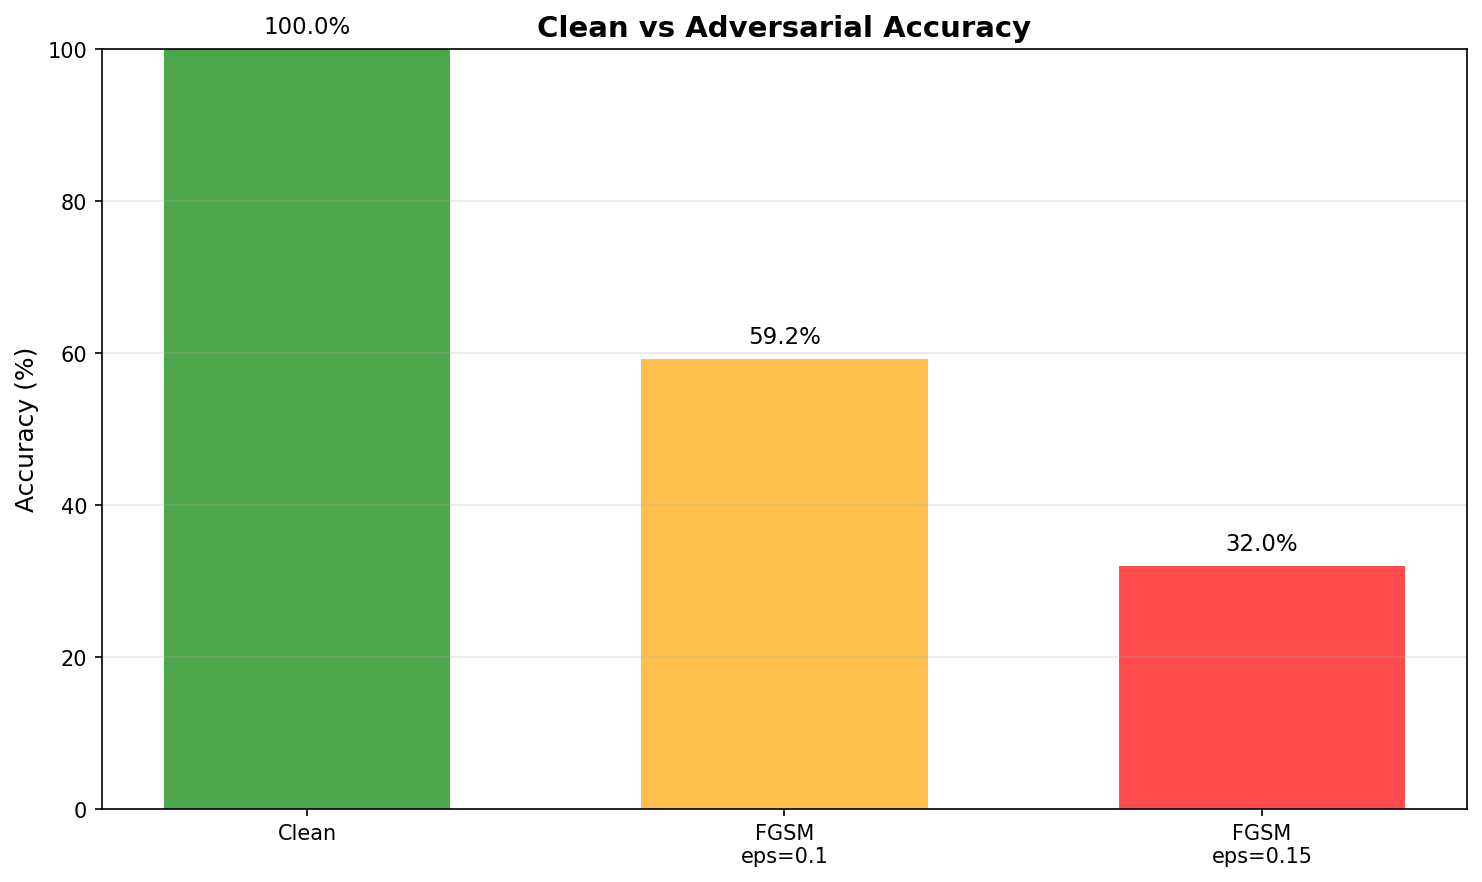

In [ ]:
print("\n" + f[0] + "\n")
img = Image.open(f[0])
display(img)


graph2_asr_bar_chart.png



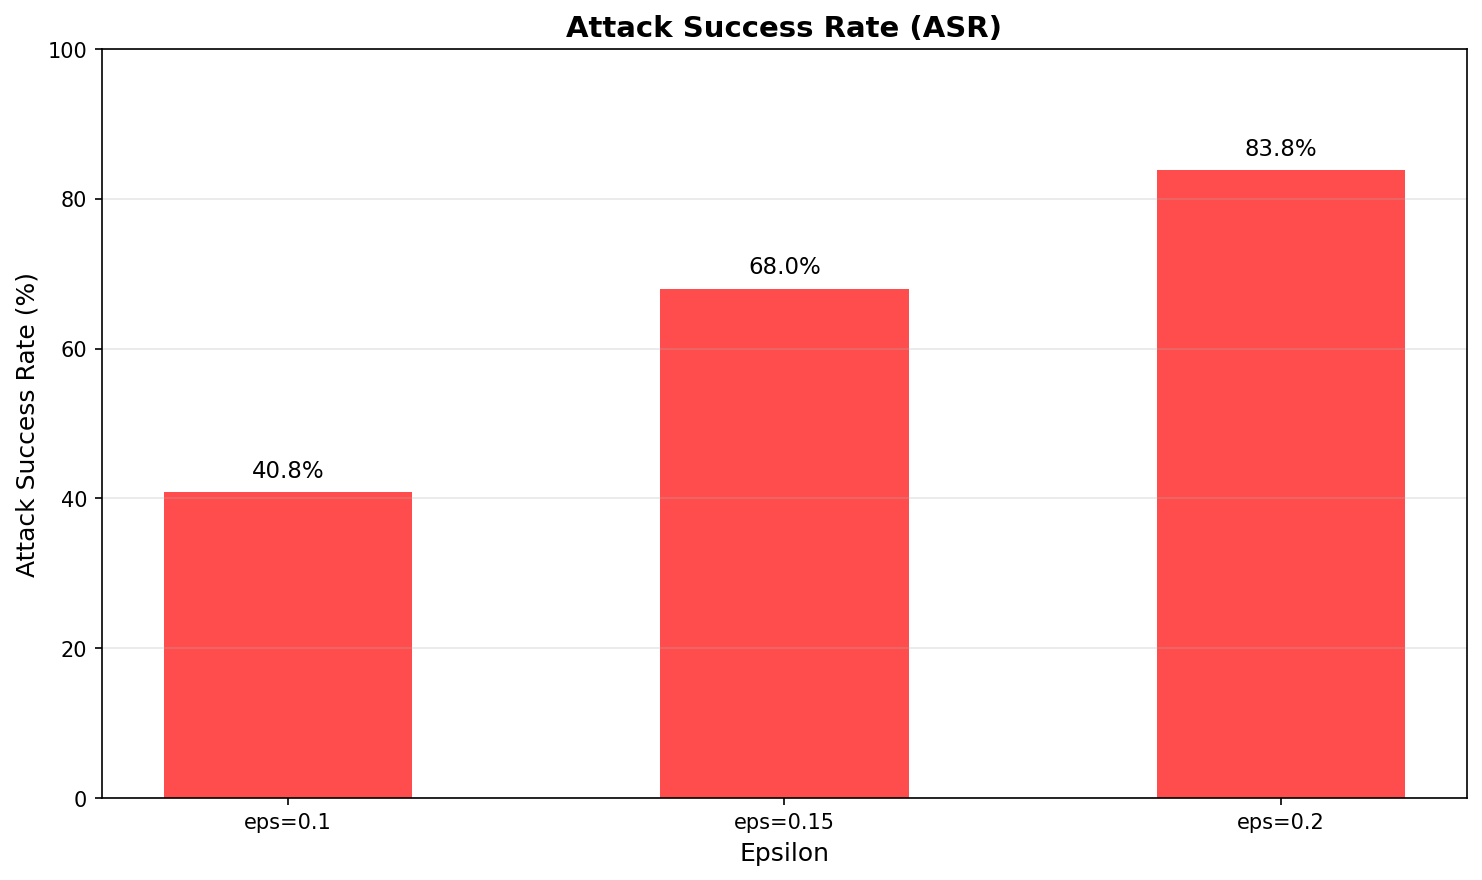

In [ ]:
print("\n" + f[1] + "\n")
img = Image.open(f[1])
display(img)


graph3_epsilon_vs_accuracy.png



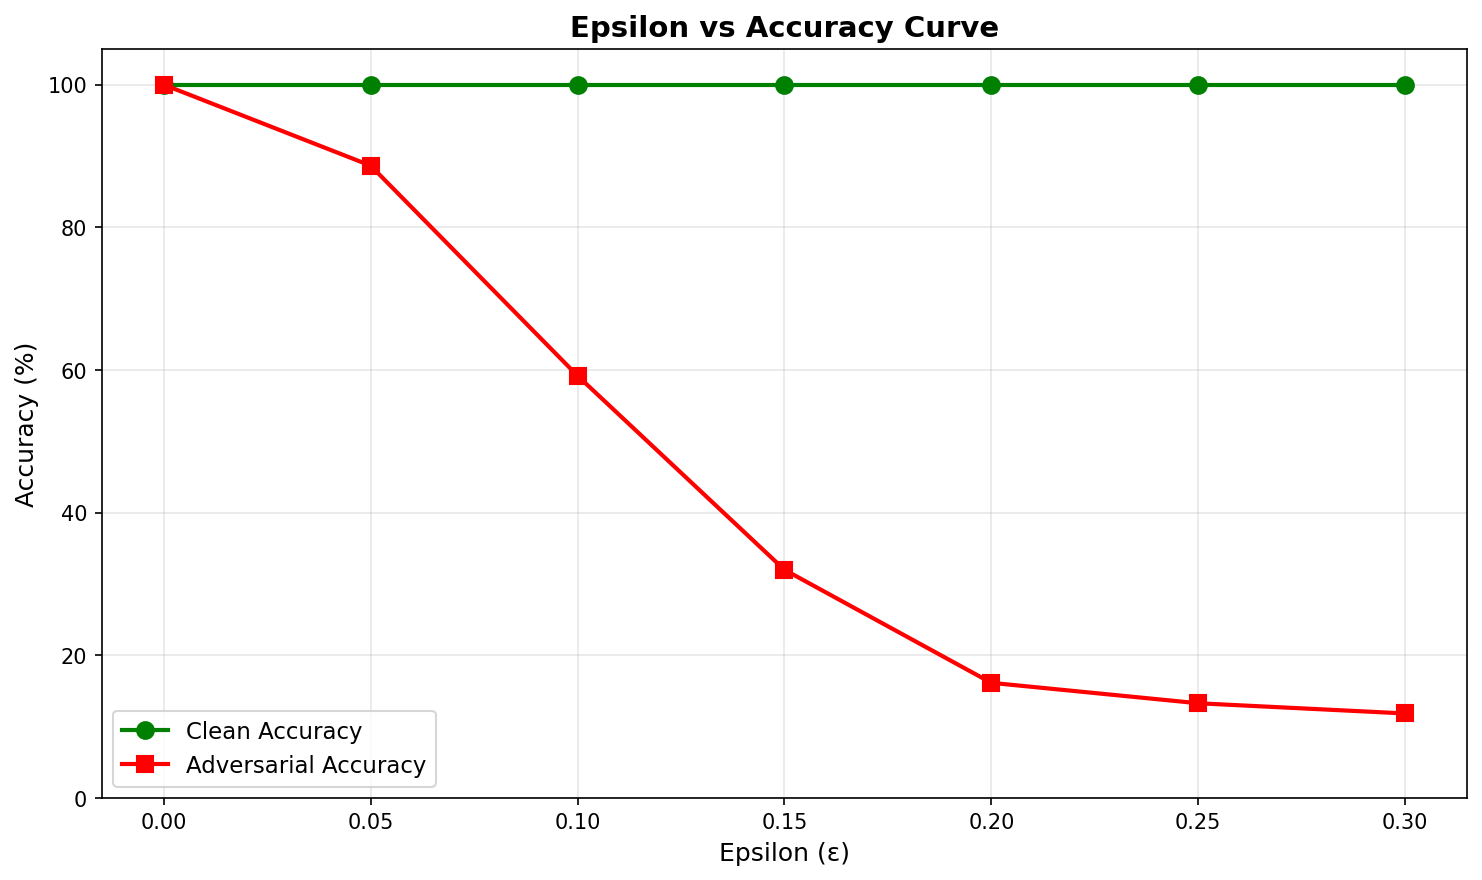

In [ ]:
print("\n" + f[2] + "\n")
img = Image.open(f[2])
display(img)


graph4_epsilon_vs_asr.png



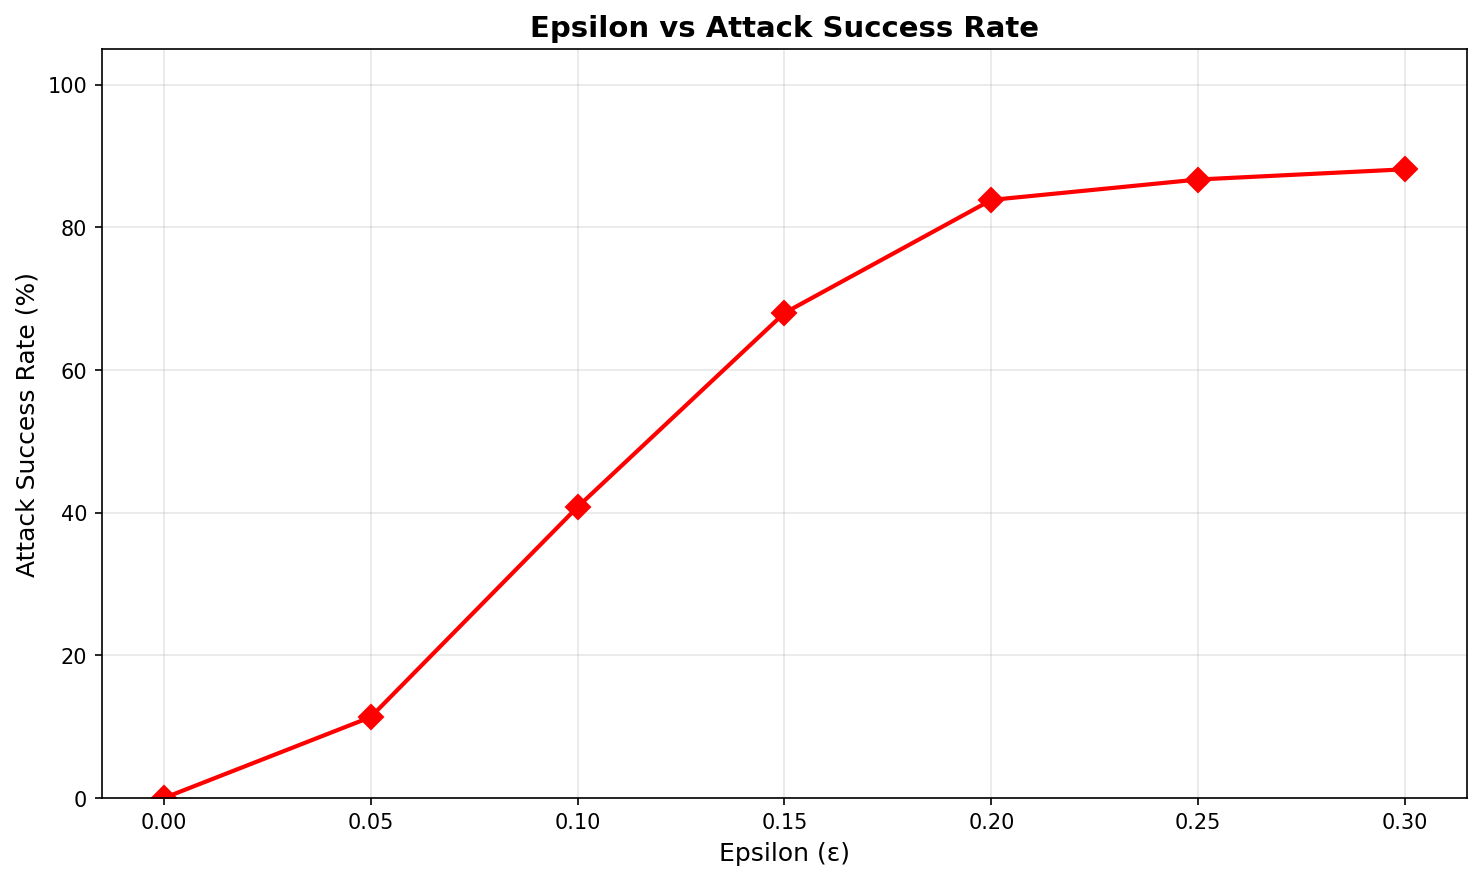

In [ ]:
print("\n" + f[3] + "\n")
img = Image.open(f[3])
display(img)


graph5_image_grid.png



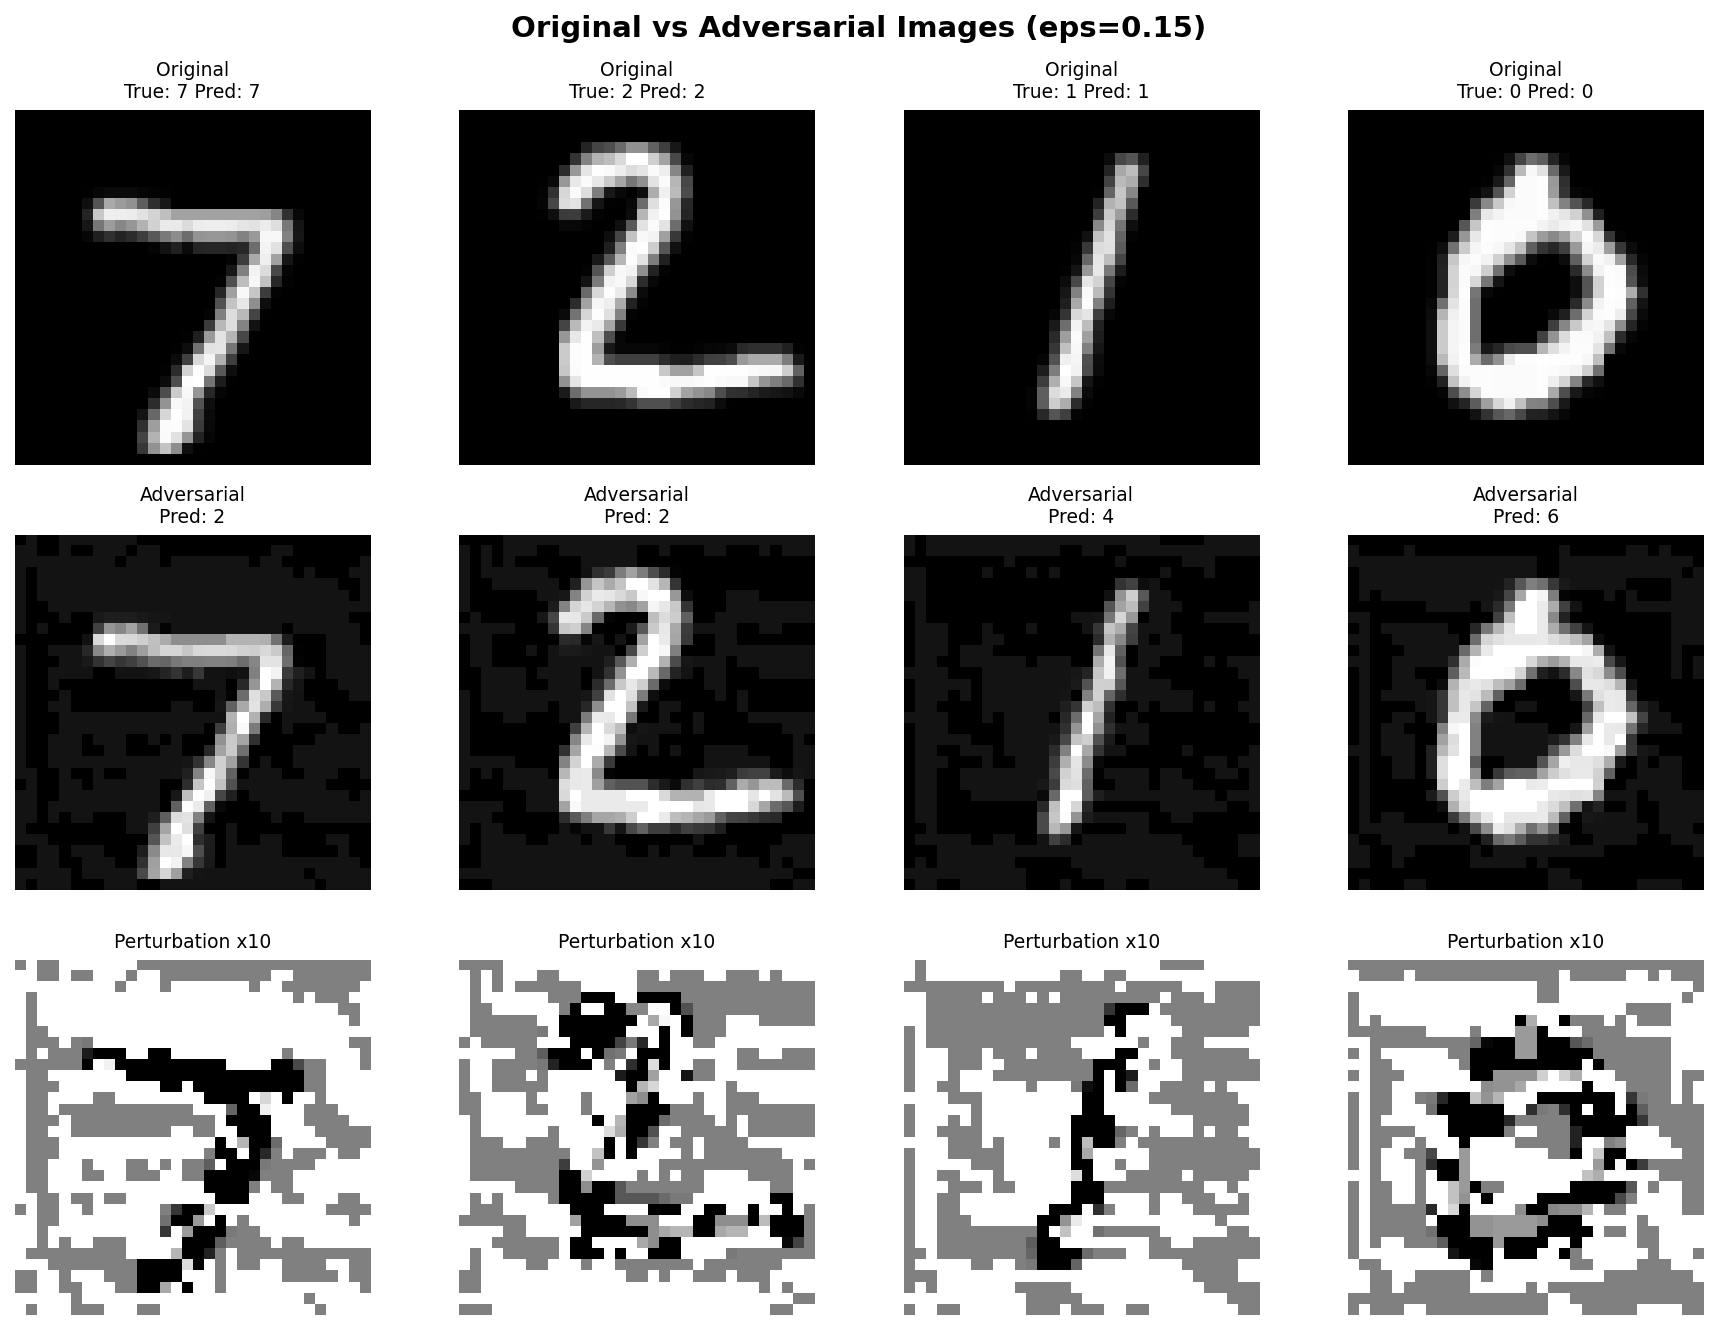

In [ ]:
print("\n" + f[4] + "\n")
img = Image.open(f[4])
display(img)


graph6_training_curves.png



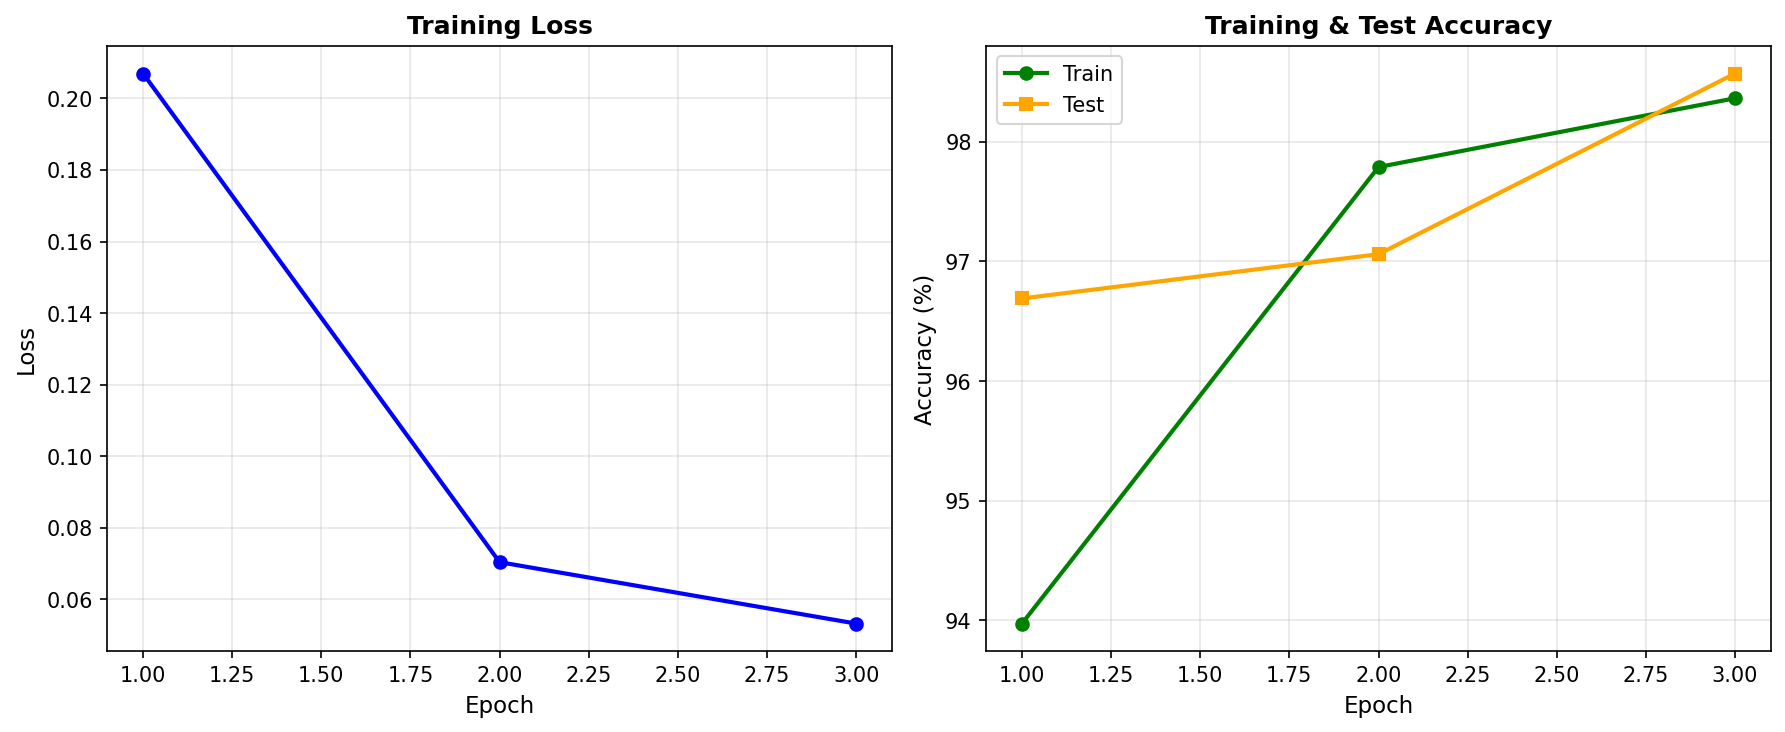

In [ ]:
print("\n" + f[5] + "\n")
img = Image.open(f[5])
display(img)


graph7_confusion_matrices.png



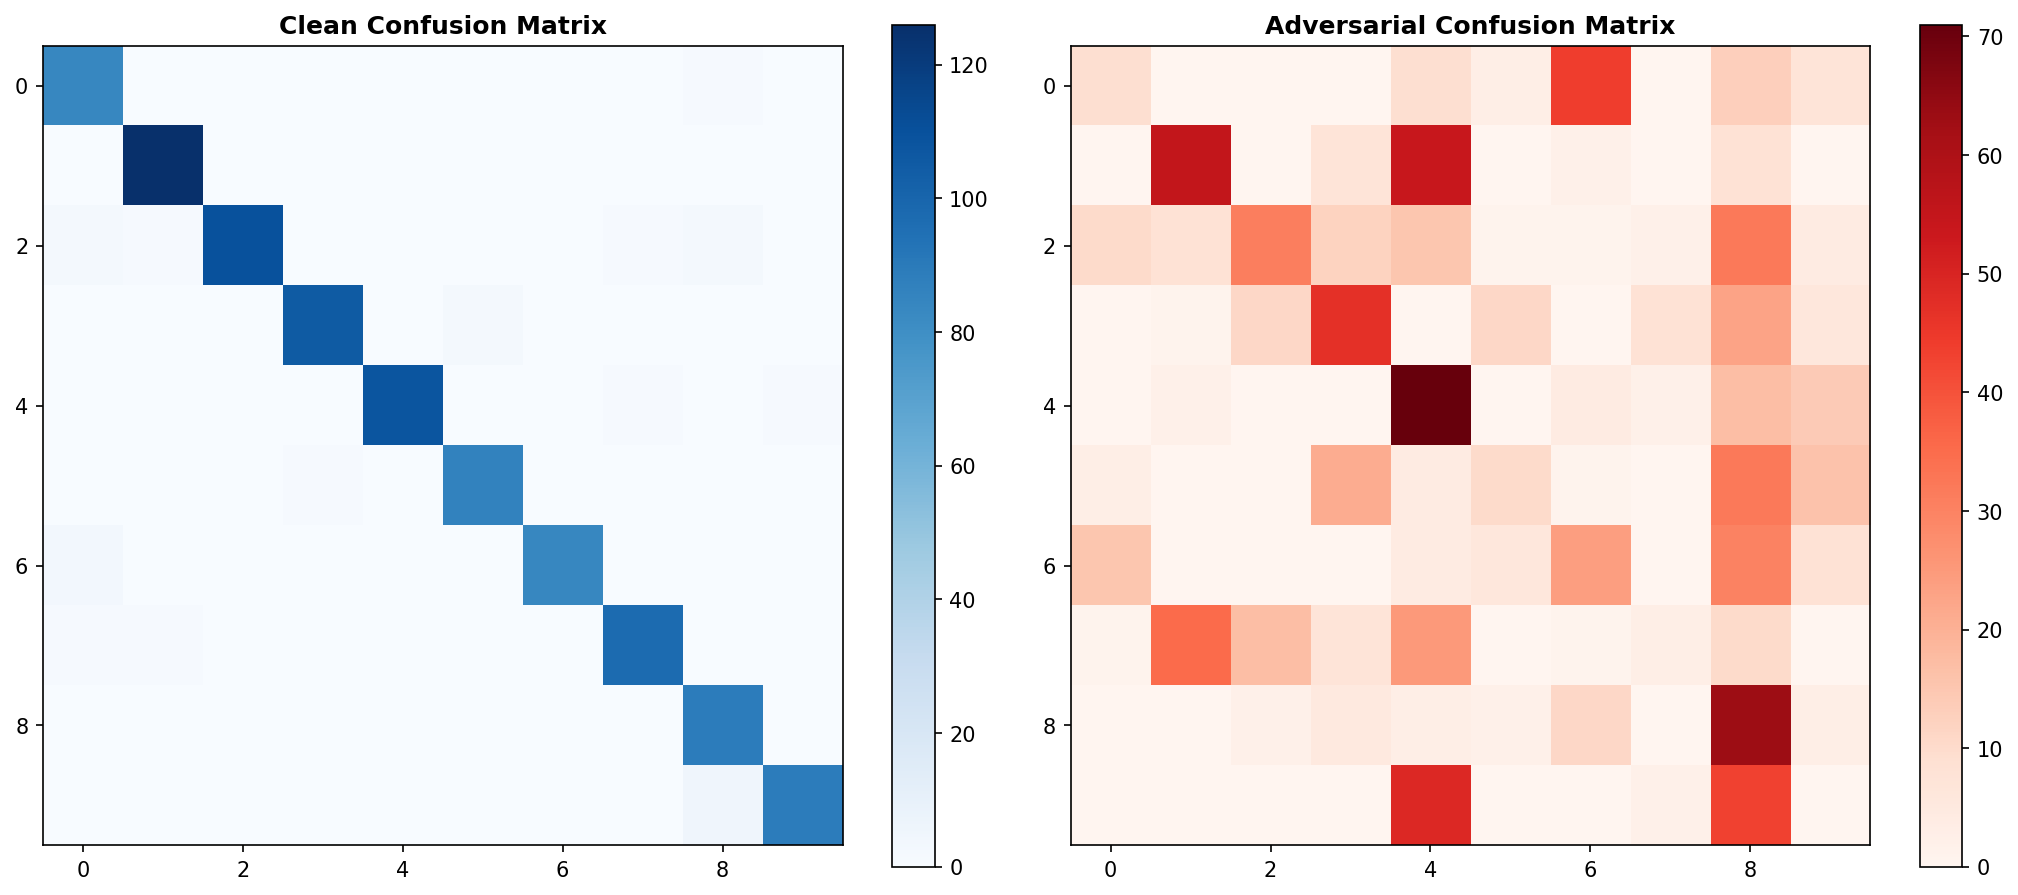

In [ ]:
print("\n" + f[6] + "\n")
img = Image.open(f[6])
display(img)


graph8_confidence_comparison.png



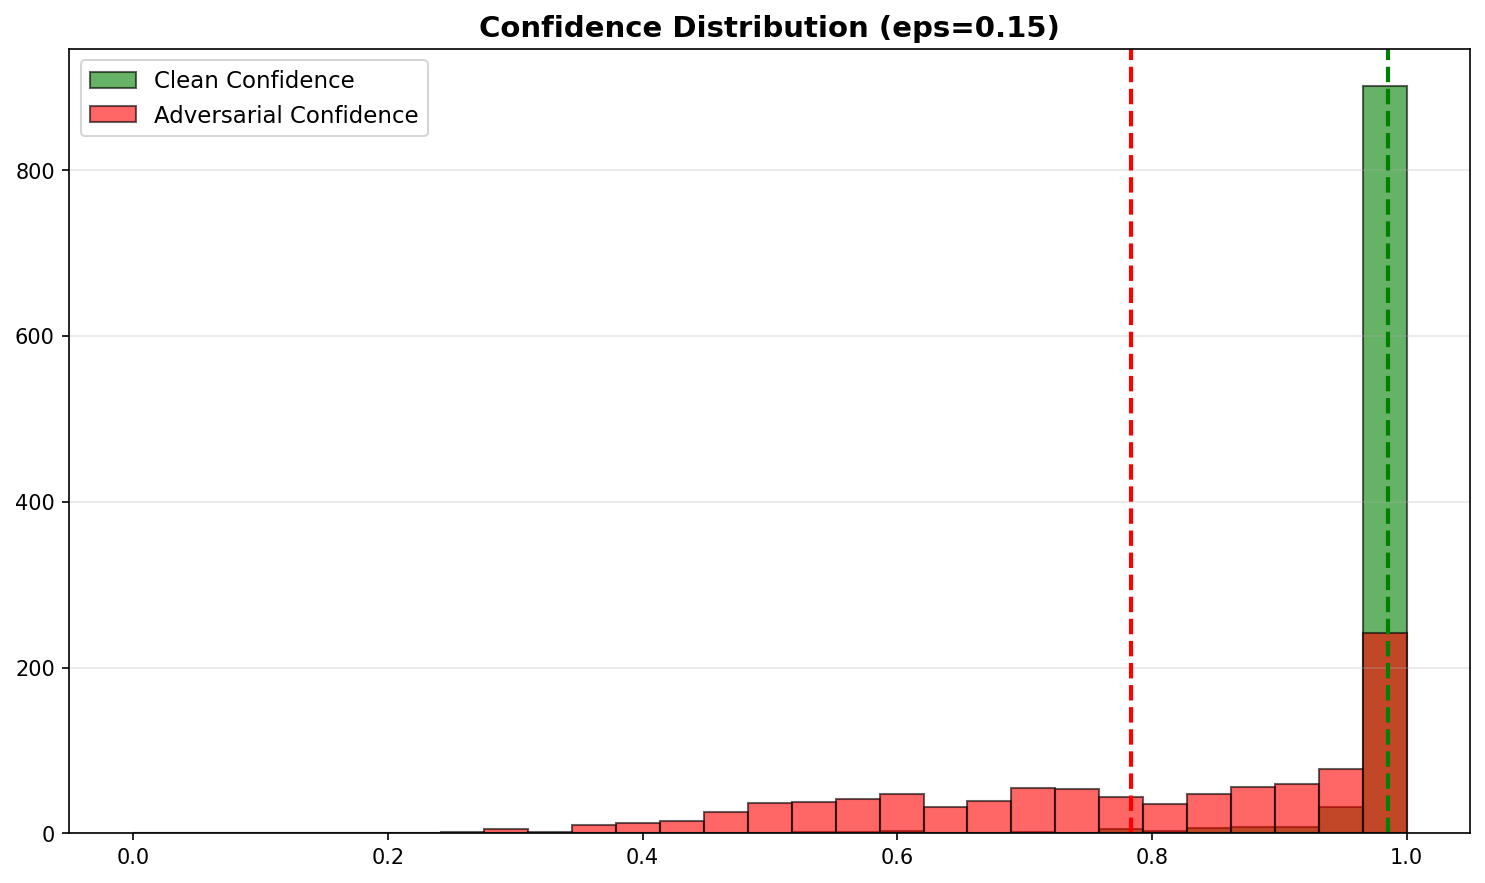

In [ ]:
print("\n" + f[7] + "\n")
img = Image.open(f[7])
display(img)